## Imports

In [40]:
import pyxdf 
import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype
from lmfit.models import Model
from os import listdir, getcwd
from os.path import isfile, join
from scipy import stats
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.formula.api as smf
import pywt
import math
import matplotlib.pyplot as plt
import statsmodels.graphics.factorplots as smgf

## Pupillary Functions


Task evoked pupillary response is calculated after correcting for luminance-induced pupil dilation: $𝑇𝐸𝑃𝑅 = 𝑑_m − 𝑑(𝑌)$, where $d_m$ is the measured pupil dilation, and $d(Y)$ is the predicted pupil dilation for the given luminance level. 

Predicted pupil dilation is calculated from a calibration sequence that produces and individual mapping model for each participant. The calibration sequence consists of 8 solid gray colors with varying luminance levels displayed in a psuedo-random order for 6 seconds each. The luminance levels span the range from 0.0 to 0.78, and for each calibration level, the first 0.5s of data is discarded to account for the initial pupillary response to the change in luminance, which can take a maximum of 0.5s. . The individual mapping model is calculated using a non-linear least squares regression to fit the equation $𝑑(𝑌) = 𝑎 · 𝑒^{−𝑏·𝑌} + c$ to the measured pupil dilation data for each participant. 

Pupil dilation data and the average luminance data were collected at 90 Hz, the display rate of the HMD.

See: Eckert, M., Robotham, T., Habets, E. A. P., and Rummukainen, O. S. (2022). Pupillary Light Reflex Correction for Robust Pupillometry in Virtual Reality. Proc. ACM Comput. Graph. Interact. Tech. 5, 1–16. doi: 10.1145/3530798

In [3]:
def pupil_func(x, a, b, c):
    return a * np.exp(-b * x) + c

In [4]:
def modmax(d):
    # compute signal modulus
    m = [0.0]*len(d)
    for i in range(len(d)):
        m[i] = math.fabs(d[i])
    # if value is larger than both neighbours , and strictly larger than either , then it is a local maximum
    t = [0.0]*len(d)
    for i in range(len(d)):
        ll = m[i -1] if i >= 1 else m[i]
        oo = m[i]
        rr = m[i+1] if i < len(d)-2 else m[i]
        if (ll <= oo and oo >= rr) and (ll < oo or oo > rr):
        # compute magnitude
            t[i] = math.sqrt(d[i]**2)
        else:
            t[i] = 0.0
    return t

In [5]:
def ipa_func(d):
    # obtain 2-level DWT of pupil diameter signal d
    try:
        (cA2 ,cD2 ,cD1) = pywt.wavedec(d,'sym16', 'per', level=2)
    except ValueError :
        return
    # get signal duration (in seconds)
    tt = d.index[-1] - d.index[0]
    # normalize by 1/2 j , j = 2 for 2-level DWT
    cA2 [:] = [x / math.sqrt (4.0) for x in cA2]
    cD1 [:] = [x / math.sqrt (2.0) for x in cD1]
    cD2 [:] = [x / math.sqrt (4.0) for x in cD2]

    # detect modulus maxima , see Listing 2
    cD2m = modmax(cD2)

    # threshold using universal threshold λuniv = σˆp(2logn)
    # where σˆ is the standard deviation of the noise
    λuniv = np.std(cD2m) * math.sqrt (2.0* np.log2(len(cD2m )))
    cD2t = pywt.threshold(cD2m ,λuniv,mode="hard")
    
    # compute IPA
    ctr = 0
    for i in range(len(cD2t )):
        if math.fabs(cD2t[i]) > 0: ctr += 1
    IPA = float(ctr)/tt.total_seconds()

    return IPA

## Statistical Functions

In [6]:
def iqr_outlier_indices(data):
    q1 = data.quantile(.25)
    q3 = data.quantile(.75)
    iqr = stats.iqr(data, nan_policy='omit', rng=(25, 75))
    return np.where((data < (q1 - 1.5 * iqr)) | (data > (q3 + 1.5 * iqr)))

In [7]:
def iqr_stats(data):
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    iqr = stats.iqr(data, nan_policy='omit', rng=(25, 75))
    return iqr, q1, q3

In [8]:
def get_results_colors(np, wp, tp):
    pastels = px.colors.qualitative.Pastel2
    default_color = 'white'
    significant_color = pastels[0]
    non_significant_color = pastels[3]

    normal_color = non_significant_color if np < 0.05 else significant_color
    wilcox_color = default_color
    ttest_color = default_color
    if np < 0.05:
        wilcox_color = significant_color if wp < 0.05 else non_significant_color
    else:
        ttest_color = significant_color if tp < 0.05 else non_significant_color

    fill_color = [[default_color, default_color, default_color],
                  [default_color, wilcox_color, ttest_color] , 
                  [normal_color, wilcox_color, ttest_color]]
    
    return fill_color

## Data Processing Functions

In [9]:
def import_data(file):
    streams, header = pyxdf.load_xdf(file)
    dfs = {}
    for stream in streams:
        stream_name = stream['info']['name'][0]
        stream_channels = {channel['label'][0]: i for i, channel in enumerate(stream['info']['desc'][0]['channels'][0]['channel'])}
        stream_data = stream['time_series']
        data_dict = {key: np.array(stream_data)[:, index] for key, index in stream_channels.items()}
        data_dict['time'] = np.round(np.array(stream['time_stamps']), decimals=4)
        dfs[stream_name] = pd.DataFrame(data_dict).drop_duplicates(subset=['time']).reset_index(drop=True)
    return dfs

In [10]:
accom_time = pd.to_timedelta(0.5, unit='s')

In [11]:
method_cats = CategoricalDtype(['4DoF','6DoF', 'unimanual','bimanual'], ordered=False)
model_cats = CategoricalDtype(['A', 'B', 'C', 'D'], ordered=True)
block_cats = CategoricalDtype(['0', '1', '2', '3'], ordered=True)
event_cats = CategoricalDtype(['Start', 'PointPlaced', 'Move', 'End', 'Draw', 'Erase', 'PointDeleted'], ordered=False)
target_cats = CategoricalDtype(['1','2'], ordered=False)
trial_cats = CategoricalDtype(['0','1','2','3'], ordered=True)
data_names = ['id', 'block', 'model', 'method']

In [12]:
mA = [0,1,3,2]
mB = [1,2,0,3]
mC = [2,3,1,0]
mD = [3,0,2,1]

tA = [0,1,2,3]
tB = [0,1,3,2]
tC = [1,0,2,3]
tD = [1,0,3,2]

model_blocks = [
    [mA,mB,mC,mD],
    [mB,mC,mD,mA],
    [mC,mD,mA,mB],
    [mD,mA,mB,mC]
]

method_blocks = [
    tA, tB, tC, tD
]

In [13]:
def process_gaze_luminance_data(stream_df):
    pupil = stream_df['GazeStream'].loc[(stream_df['GazeStream']['LeftEyeIsBlinking'] == 0) 
                                        & (stream_df['GazeStream']['RightEyeIsBlinking'] == 0) 
                                        & (stream_df['GazeStream']['LeftPupilDiameter'] > 0) 
                                        & (stream_df['GazeStream']['RightPupilDiameter'] > 0), 
                                        ['time', 'trial_id', 'MethodID', 'ModelID', 'LeftPupilDiameter', 'RightPupilDiameter']]
    pupil['time'] = pd.to_timedelta(pupil['time'], unit='s')

    lum = stream_df['LuminanceStream'].loc[:, ['time', 'MethodID', 'ModelID', 'Luminance']]
    lum['time'] = pd.to_timedelta(lum['time'], unit='s')

    # Intersection of time stamps
    pupil_lum_time_intersection = np.intersect1d(pupil['time'], lum['time'])

    # Filter pupil and luminance data by intersection
    pupil = pupil[pupil['time'].isin(pupil_lum_time_intersection)].reset_index(drop=True)
    lum = lum[lum['time'].isin(pupil_lum_time_intersection)].reset_index(drop=True)

    # Combined DataFrame for pupil and luminance
    pupil_lum = pd.DataFrame({
        'time': pd.to_timedelta(pupil_lum_time_intersection, unit='s'),
        'luminance': lum['Luminance'],
        'pupilDiameter': 0.5 * (pupil['LeftPupilDiameter'] + pupil['RightPupilDiameter']),
        'methodID': pupil['MethodID'],
        'modelID': pupil['ModelID'],
        'trial_id': pupil['trial_id']
    })

    outliers = iqr_outlier_indices(pupil_lum['pupilDiameter'])
    pupil_lum = pupil_lum.drop(pupil_lum.iloc[outliers].index).reset_index(drop=True)

    return pupil_lum

In [14]:
def process_calibration_data(pupil_lum_df, stream_df):
    calibration_events = stream_df['ExperimentStream'].loc[(stream_df['ExperimentStream']['EventType'] == 'CalibrationColorChange') | 
                                                           (stream_df['ExperimentStream']['SceneEvent'] == 'Calibration') | 
                                                           (stream_df['ExperimentStream']['SceneEvent'] == 'CalibrationComplete'), 
                                                           ['time','SceneEvent', 'EventType']]
    calibration_events['time'] = pd.to_timedelta(calibration_events['time'], unit='s')
    c_start_times = calibration_events[:8]['time']
    c_end_times = calibration_events[1:]['time']
    c_start_times.reset_index(drop=True, inplace=True)
    c_end_times.reset_index(drop=True, inplace=True)

    calib_data = {}
    for i in range(8):
        calib_data[i] = pupil_lum_df.loc[(pupil_lum_df['time'] >= c_start_times[i]) & (pupil_lum_df['time'] <= c_end_times[i]), ['time','luminance', 'pupilDiameter']]
        calib_data[i]['time'] -= calib_data[i]['time'].iloc[0]
        calib_data[i] = calib_data[i].loc[(calib_data[i]['time'] >= accom_time), ['luminance', 'pupilDiameter']]

    calibration_data = pd.concat(calib_data).groupby(level=0).mean().sort_values(by=['luminance']).reset_index(drop=True)
    return calibration_data

In [15]:
def process_navigation_data(pupil_lum_df, stream_df, a, b, c):
    grouped_data = stream_df['NavigationStream'].groupby(['ModelID', 'MethodID'])

    stream_df['SurveyStream']['ModelID'] = stream_df['SurveyStream']['ModelID'].astype(float)
    stream_df['SurveyStream']['MethodID'] = stream_df['SurveyStream']['MethodID'].astype(float)
    
    discomfort_survey = stream_df['SurveyStream'].loc[
        (stream_df['SurveyStream']['SurveyType'] == 'Discomfort') & 
        (stream_df['SurveyStream']['ModelID'] < 4), 
        ['time', 'ModelID', 'MethodID']]
    survey_group = discomfort_survey.groupby(['ModelID', 'MethodID'])

    start_times = []
    end_times = []
    total_time = []

    for i in range(4):
        for j in range(2,4):
            trial = grouped_data.get_group((i, j))

            start = trial.loc[(trial['spline_percent'] > 0.001)].index[0]
            start_time = pd.to_timedelta(stream_df['NavigationStream'].loc[start, 'time'], unit='s')

            end = trial.loc[(trial['spline_percent'] > 0.995)]
            end_time = 0
            # For 6DoF navigation, completion was determined by collision with bounding box
            # Spline percentage was based on projection, so it may not reach > 0.995.
            # In this case, the survey time serves as the end time (rather than lowering the threshold)
            if len(end) > 0:
                end = end.index[0]
                end_time = pd.to_timedelta(stream_df['NavigationStream'].loc[end, 'time'], unit='s')
            else:
                end = survey_group.get_group((i, j)).index[0]
                end_time = pd.to_timedelta(stream_df['SurveyStream'].loc[end, 'time'], unit='s') - pd.offsets.Second(3)
            
            start_times.append(start_time)
            end_times.append(end_time)
            total_time.append((end_time - start_time).total_seconds())


    nav_start_times = start_times
    nav_end_times = end_times

    nav_data = {}
    for i in range(8):
        nav_data[i] = pupil_lum_df.loc[
            (pupil_lum_df['luminance'] >0) & 
            (pupil_lum_df['time']>nav_start_times[i]) & 
            (pupil_lum_df['time']<nav_end_times[i]), 
            ['time', 'trial_id', 'methodID', 'modelID', 'luminance', 'pupilDiameter']]
        nav_data[i].reset_index(drop=True, inplace=True)

    navigation_data = pd.concat(nav_data, names=['trial'])
    navigation_data['pupil_lum_base'] = pupil_func(navigation_data['luminance'], a, b, c)
    navigation_data['adj_pupil'] = navigation_data['pupilDiameter'] - navigation_data['pupil_lum_base']

    return navigation_data, total_time

In [16]:
def clean_stream(stream_df, block, range_frame):
    df = pd.DataFrame()

    for col in stream_df.columns:
        df[col] = stream_df[col]
    
    stream_df['ModelID'] = stream_df['ModelID'].mask(stream_df['ModelID'] == 'generic', '99')
    stream_df['MethodID'] = stream_df['MethodID'].mask(stream_df['MethodID'] == 'generic', '99')
    df['ModelID'] = stream_df['ModelID'].astype(int)
    df['trial_id'] = stream_df['ModelID'].astype(int)
    df['MethodID'] = stream_df['MethodID'].astype(int)

    for i in range(4):
        for j in range_frame:
            method = method_blocks[block][j]
            df['ModelID'] = df['ModelID'].mask((df['trial_id']==i) & (df['MethodID']==method), model_blocks[block][j][i])
    
    return df

In [17]:
def process_creation_data(pupil_lum_df, stream_df, a, b, c):
    
    crt_start_times = stream_df['CreationStream'].loc[(stream_df['CreationStream']['EventName'] == 'StartPointRegistered'), ['time', 'ModelID', 'MethodID']]
    crt_start_times = pd.to_timedelta(crt_start_times.groupby(['ModelID', 'MethodID']).first()['time'], unit='s') + pd.offsets.Second(2)
    crt_start_times.reset_index(drop=True, inplace=True)

    crt_end_times = stream_df['CreationStream'].loc[(stream_df['CreationStream']['EventName'] == 'FinishPath'), ['time', 'ModelID', 'MethodID']]
    crt_end_times = pd.to_timedelta(crt_end_times.groupby(['ModelID', 'MethodID']).first()['time'], unit='s')
    crt_end_times.reset_index(drop=True, inplace=True)
    
    total_time = crt_end_times - crt_start_times
    total_time = total_time.apply(lambda x: x.total_seconds())

    crt_data = {}
    for i in range(8):
        crt_data[i] = pupil_lum_df.loc[
            (pupil_lum_df['time'] > crt_start_times.loc[i]) & 
            (pupil_lum_df['time'] < crt_end_times.loc[i]), 
            ['time', 'methodID',  'trial_id', 'modelID', 'luminance', 'pupilDiameter']]
        crt_data[i].reset_index(drop=True, inplace=True)

    creation_data = pd.concat(crt_data, names=['trial'])
    creation_data['pupil_lum_base'] = pupil_func(creation_data['luminance'], a, b, c)
    creation_data['adj_pupil'] = creation_data['pupilDiameter'] - creation_data['pupil_lum_base']
    
    return creation_data, total_time

In [18]:
def process_creation_stats(stream_df):

    group = stream_df['CreationStream'].groupby(['ModelID', 'MethodID'])
    creation_counts  = []

    for i in range(4):
            for j in range(0,2):
                trial = group.get_group((i,j))
                creation_counts.append(trial.groupby('EventType', observed=False).size().fillna(0))
    
    keys = [(i,j) for i in range(4) for j in range(0,2)]
    creation_stats = pd.concat(creation_counts, axis=0, keys=keys, names=['ModelID', 'MethodID']).unstack(level=2)
    creation_stats = creation_stats.drop(columns=['End', 'Start'])
    return creation_stats

In [19]:
def process_target_trial_data_crt(stream_df):
    target_set = stream_df['ExperimentStream'].loc[
        (stream_df['ExperimentStream']['EventType'] == 'TargetPointsSet') | 
        (stream_df['ExperimentStream']['EventType'] == 'SceneLoaded') & 
        (stream_df['ExperimentStream']['SceneEvent'] != 'Calibration') & 
        (stream_df['ExperimentStream']['MethodID'] != 2) & 
        (stream_df['ExperimentStream']['MethodID'] != 3), ['SceneEvent', 'EventType', 'ModelID', 'MethodID']]

    generic_idx = np.where(target_set['ModelID'] == 99)[0]
    idx = [x+1 for x in generic_idx]

    for i in range(len(generic_idx)):
        target_set.loc[target_set.index[generic_idx[i]], 'ModelID']  = target_set.loc[target_set.index[idx[i]], 'ModelID']
        target_set.loc[target_set.index[generic_idx[i]], 'MethodID']  = target_set.loc[target_set.index[idx[i]], 'MethodID']

    target_set = target_set.loc[(target_set['ModelID'] < 4) & (target_set['EventType'] == 'TargetPointsSet'), ['SceneEvent', 'ModelID', 'MethodID']]

    target_set['SceneEvent'] = target_set.mask(target_set['SceneEvent'] == 'TargetsLoaded_Set1', target_cats.categories[0])['SceneEvent']
    target_set['SceneEvent'] = target_set.mask(target_set['SceneEvent'] == 'TargetsLoaded_Set2', target_cats.categories[1])['SceneEvent']

    target_set['targetID'] = target_set['SceneEvent']
    target_set.drop(columns=['SceneEvent'], inplace=True)

    return target_set


In [20]:
def process_target_trial_data_nav(stream_df, target_set_group):
    target_set = stream_df['NavigationStream'].loc[(stream_df['NavigationStream']['ModelID'] < 4), ['model_source', 'ModelID', 'MethodID']]

    groups = target_set.groupby(['ModelID', 'MethodID'])

    target_set['creation_method'] = '-1'
    target_set['target_set_source'] = '-1'

    target_trials = []

    for i in range(4):
        for j in range(2,4):
            trial = groups.get_group((i, j))
            model_source = trial['model_source'].iloc[0]
            model_value16 = model_source - 16
            method = '-1'
            method_id = -1

            if model_value16 > 9:
                method = 'bimanual'
                method_id = 1
            else:
                method = 'unimanual'
                method_id = 0

            trial.loc[:, 'creation_method'] = method

            model_i = trial['ModelID'].iloc[0]
            group = target_set_group.get_group((int(model_i),int(method_id)))

            target = group['targetID'].iloc[0]
            trial.loc[:, 'target_set_source'] = target
            target_trials.append(trial.iloc[:1])

    target_set = pd.concat(target_trials)

    target_set['creation_method'] = target_set['creation_method'].astype('string').astype(method_cats)
    target_set['target_set_source'] = target_set['target_set_source'].astype('string').astype(target_cats)
    target_set.drop(columns=['model_source'], inplace=True)
    target_set.reset_index(drop=True, inplace=True)

    return target_set

In [21]:
def process_discomfort_data(stream_df):
    discomfort_values = stream_df['SurveyStream'].loc[stream_df['SurveyStream']['SurveyType'] == 'Discomfort', ['time', 'Value', 'ModelID', 'MethodID']]
    discomfort_values['time'] = pd.to_timedelta(discomfort_values['time'], unit='s')
    discomfort_values.reset_index(drop=True, inplace=True)
    return discomfort_values

In [22]:
def process_seq_data(stream_df):
    seq_values = stream_df['SurveyStream'].loc[stream_df['SurveyStream']['SurveyType'] == 'SEQ', ['time', 'Value', 'ModelID', 'MethodID']]
    seq_values['time'] = pd.to_timedelta(seq_values['time'], unit='s')
    seq_values.reset_index(drop=True, inplace=True)
    return seq_values

In [23]:
def process_ipa_calc(data):
    methods = []
    models = []
    ipa = []
    for i in range(8):
        methods.append(data.loc[i]['methodID'].iloc[i])
        models.append(data.loc[i]['modelID'].iloc[i])
        pupil = data.loc[i]['pupilDiameter']
        pupil.index = data.loc[i]['time']
        ipa.append(ipa_func(pupil))
        
    return pd.DataFrame({'methodID': methods, 'modelID': models, 'IPA': ipa})

## Import Data

In [24]:
data_dir = join(getcwd(),'Path_Data')
data_files = [join(data_dir, f) for f in listdir(data_dir) if isfile(join(data_dir, f))]

In [25]:
dfs = []
for file in data_files:
    df = import_data(file)
    #'LuminanceStream', 'GazeStream', 'NavigationStream', 'CreationStream', 'PoseStream', 'ExperimentStream', 'SurveyStream', 'TrackedPoseStream'
    # Remove final empty row from string data streams
    df['SurveyStream'] = df['SurveyStream'].replace(r'^\s*$', np.nan, regex=True).dropna()
    df['CreationStream'] = df['CreationStream'].replace(r'^\s*$', np.nan, regex=True).dropna()
    df['ExperimentStream'] = df['ExperimentStream'].replace(r'^\s*$', np.nan, regex=True).dropna()

    df['SurveyStream']['ModelID'] = df['SurveyStream']['ModelID'].astype(float)
    df['SurveyStream']['MethodID'] = df['SurveyStream']['MethodID'].astype(float)
    df['SurveyStream']['Value'] = df['SurveyStream']['Value'].astype(float)

    df['CreationStream']['ModelID'] = df['CreationStream']['ModelID'].astype(float)
    df['CreationStream']['MethodID'] = df['CreationStream']['MethodID'].astype(float)
    df['CreationStream']['EventType'] = df['CreationStream']['EventType'].astype(event_cats)

    block = int(df['ExperimentStream']['BlockID'][0])
    df['GazeStream'] = clean_stream(df['GazeStream'], block, range(4))
    df['LuminanceStream'] = clean_stream(df['LuminanceStream'], block, range(4))
    df['NavigationStream'] = clean_stream(df['NavigationStream'], block, range(2,4))
    df['CreationStream'] = clean_stream(df['CreationStream'], block, range(2))
    df['PoseStream'] = clean_stream(df['PoseStream'], block, range(4))
    df['SurveyStream'] = clean_stream(df['SurveyStream'], block, range(4))
    df['TrackedPoseStream'] = clean_stream(df['TrackedPoseStream'], block, range(4))
    df['ExperimentStream'] = clean_stream(df['ExperimentStream'], block, range(4))
    dfs.append(df)

## Process Data

In [26]:
user_dfs_nav = []
user_dfs_crt = []
ids = []
blocks = []

for df in dfs:
    id = df['ExperimentStream']['UserID'][0]
    block = df['ExperimentStream']['BlockID'][0]
    ids.append(id)
    blocks.append(block)

    pupil_lum_df = process_gaze_luminance_data(df)
    calibration_data = process_calibration_data(pupil_lum_df, df)

    # Fit pupil response to luminance
    x_data = calibration_data['luminance']
    y_data = calibration_data['pupilDiameter']
    exp_mod = Model(pupil_func)
    params = exp_mod.make_params(a=1, b=4, c=0)
    result = exp_mod.fit(y_data, params, x=x_data)
    a = result.params['a'].value
    b = result.params['b'].value
    c = result.params['c'].value

    navigation_data, nav_time = process_navigation_data(pupil_lum_df, df, a, b, c)
    ipa_calc_nav = process_ipa_calc(navigation_data)
    creation_data, crt_time = process_creation_data(pupil_lum_df, df, a, b, c)
    ipa_calc_crt = process_ipa_calc(creation_data)
    creation_stats = process_creation_stats(df)
    discomfort = process_discomfort_data(df)
    seq = process_seq_data(df)

    creation_target_trials = process_target_trial_data_crt(df)
    crt_target_trials = creation_target_trials.groupby(['ModelID', 'MethodID'])
    navigation_target_trials = process_target_trial_data_nav(df, crt_target_trials)
    nav_target_trials = navigation_target_trials.groupby(['ModelID', 'MethodID'])

    nav_trials = navigation_data.groupby(['modelID', 'methodID'])
    ipa_nav_trials = ipa_calc_nav.groupby(['modelID', 'methodID'])
    crt_trials = creation_data.groupby(['modelID', 'methodID'])
    ipa_crt_trials = ipa_calc_crt.groupby(['modelID', 'methodID'])
    discomfort_trials = discomfort.groupby(['ModelID', 'MethodID'])
    seq_trials = seq.groupby(['ModelID', 'MethodID'])
    
    nav_data = {}
    nav_total_time = {}
    ipa_nav_data = {}
    crt_data = {}
    crt_total_time = {}
    ipa_crt_data = {}
    discomfort_data = {}
    seq_crt = {}
    seq_nav = {}
    target_data_crt = {}
    target_data_nav = {}
    creation_data_nav = {}

    for i in range(4):
        for j in range(2,4):
            nav_data[(id, block, i, j)] = nav_trials.get_group((i,j)).mean()
            nav_total_time[(id, block, i, j)] = nav_time[(2*i + (j-2))]
            ipa_nav_data[(id, block, i, j)] = ipa_nav_trials.get_group((i,j)).mean()
            discomfort_data[(id, block, i, j)] = discomfort_trials.get_group((i,j)).mean()
            seq_nav[(id, block, i, j)] = seq_trials.get_group((i,j)).mean()
            target_data_nav[(id, block, i, j)] = nav_target_trials.get_group((i,j))['target_set_source'].iloc[0]
            creation_data_nav[(id, block, i, j)] = nav_target_trials.get_group((i,j))['creation_method'].iloc[0]
    
    for i in range(4):
        for j in range(0,2):
            crt_data[(id, block, i, j)] = crt_trials.get_group((i,j)).mean()
            crt_total_time[(id, block, i, j)] = crt_time[(2*i + j)]
            ipa_crt_data[(id, block, i, j)] = ipa_crt_trials.get_group((i,j)).mean()
            seq_crt[(id, block, i, j)] = seq_trials.get_group((i,j)).mean()
            target_data_crt[(id, block, i, j)] = crt_target_trials.get_group((i,j))['targetID'].iloc[0]
    
    nav_index = pd.MultiIndex.from_product([[id], [block], model_cats.categories, method_cats.categories[0:2]], names=data_names)
    crt_index = pd.MultiIndex.from_product([[id], [block], model_cats.categories, method_cats.categories[2:4]], names=data_names)

    nav_data = pd.concat(nav_data, axis=1, names=data_names).T
    nav_data['total_time'] = nav_total_time
    nav_data['target_source'] = target_data_nav
    nav_data['creation_method'] = creation_data_nav
    nav_data.index = nav_index
    nav_data.drop(columns=['time', 'modelID', 'methodID'], inplace=True)
    
    crt_data = pd.concat(crt_data, axis=1, names=data_names).T
    crt_data['total_time'] = crt_total_time
    crt_data['target_id'] = target_data_crt
    crt_data.index = crt_index
    crt_data.drop(columns=['time', 'modelID', 'methodID'], inplace=True)

    creation_stats.index = crt_index

    ipa_nav_data = pd.concat(ipa_nav_data, axis=1, names=data_names).T
    ipa_nav_data.index = nav_index
    ipa_nav_data.drop(columns=['modelID', 'methodID'], inplace=True)

    ipa_crt_data = pd.concat(ipa_crt_data, axis=1, names=data_names).T
    ipa_crt_data.index = crt_index
    ipa_crt_data.drop(columns=['modelID', 'methodID'], inplace=True)

    discomfort_data = pd.concat(discomfort_data, axis=1, names=data_names).T
    discomfort_data.index = nav_index
    discomfort_data['discomfort'] = discomfort_data['Value']
    discomfort_data.drop(columns=['time', 'ModelID', 'MethodID', 'Value'], inplace=True)

    seq_nav = pd.concat(seq_nav, axis=1, names=data_names).T
    seq_nav.index = nav_index
    seq_nav['seq'] = seq_nav['Value']
    seq_nav.drop(columns=['time', 'ModelID', 'MethodID', 'Value'], inplace=True)

    seq_crt = pd.concat(seq_crt, axis=1, names=data_names).T
    seq_crt.index = crt_index
    seq_crt['seq'] = seq_crt['Value']
    seq_crt.drop(columns=['time', 'ModelID', 'MethodID', 'Value'], inplace=True)

    df_crt = pd.concat([crt_data, ipa_crt_data, seq_crt, creation_stats], axis=0).stack().unstack()
    df_crt.loc[(slice(None), slice(None), slice(None), slice(None)), ('Draw', 'Erase', 'PointPlaced', 'Move', 'PointDeleted')] = df_crt.loc[(slice(None), slice(None), slice(None), slice(None)), ('Draw', 'Erase', 'PointPlaced', 'Move', 'PointDeleted')].astype(int)
    df_crt.loc[(slice(None), slice(None), slice(None), 'unimanual'), ('Draw', 'Erase')] = df_crt.loc[(slice(None), slice(None), slice(None), 'unimanual'), ('Draw', 'Erase')].astype(int).fillna(0)
    df_crt.loc[(slice(None), slice(None), slice(None), 'bimanual'), ('PointPlaced', 'Move', 'PointDeleted')] = df_crt.loc[(slice(None), slice(None), slice(None), 'bimanual'), ('PointPlaced', 'Move', 'PointDeleted')].astype(int).fillna(0)

    df_nav = pd.concat([nav_data, ipa_nav_data, discomfort_data, seq_nav], axis=0).stack().unstack()

    user_dfs_nav.append(df_nav)
    user_dfs_crt.append(df_crt)


In [27]:
user_data_nav = pd.concat(user_dfs_nav)
nav_dtype = {'luminance': 'float64', 'pupilDiameter': 'float64', 'pupil_lum_base': 'float64', 'adj_pupil': 'float64', 'IPA': 'float64', 'discomfort': 'int32', 'seq': 'int32', 'total_time': 'float64'}
user_data_nav = user_data_nav.astype(nav_dtype)

short_nav = user_data_nav['total_time'] < 10
user_data_nav = user_data_nav[~short_nav]

user_data_crt = pd.concat(user_dfs_crt)
crt_dtype = {'luminance' : 'float64', 'pupilDiameter' : 'float64', 'pupil_lum_base' : 'float64', 'adj_pupil' : 'float64', 'IPA' : 'float64', 'seq' : 'int32', 'PointPlaced' : 'int32', 'Move' : 'int32', 'Draw' : 'int32', 'Erase' : 'int32', 'PointDeleted' : 'int32', 'total_time': 'float64'}
user_data_crt = user_data_crt.astype(crt_dtype)

short_crt = user_data_crt['total_time'] < 10
user_data_crt = user_data_crt[~short_crt]

In [28]:
user_data_nav

trial_id  luminance  pupilDiameter  pupil_lum_base  \
id  block model method                                                      
108 0     A     4DoF        3.0   0.224356       4.866458        3.831577   
                6DoF        1.0   0.225511       4.359483        3.829147   
          B     4DoF        2.0   0.242239       4.650883        3.771303   
                6DoF        3.0   0.256185       4.437137        3.746679   
          C     4DoF        0.0   0.223505       4.658904        3.852900   
...                         ...        ...            ...             ...   
142 2     B     6DoF        0.0   0.241266       4.278475        4.030461   
          C     4DoF        3.0   0.216289       4.107276        4.072612   
                6DoF        1.0   0.237670       4.267001        4.026107   
          D     4DoF        2.0   0.249396       4.071927        4.000206   
                6DoF        3.0   0.198579       4.521441        4.111343   

                        adj_pupil  total_time target_source creation_method  \
id  block model method                                                        
108 0     A     4DoF     1.034881     37.0822             1       unimanual   
                6DoF     0.530336     61.0043             2        bimanual   
          B     4DoF     0.879580     67.7005             1       unimanual   
                6DoF     0.690458     96.4316             2        bimanual   
          C     4DoF     0.806004     88.0356             1       unimanual   
...                           ...         ...           ...             ...   
142 2     B     6DoF     0.248014     63.9009             1        bimanual   
          C     4DoF     0.034664     53.5856             2       unimanual   
                6DoF     0.240894     55.2500             1        bimanual   
          D     4DoF     0.071722     46.9101             2       unimanual   
                6DoF     0.410098     43.3471             1        bimanual   

                             IPA  discomfort  seq  
id  block model method                             
108 0     A     4DoF    0.242846           2    0  
                6DoF    0.098389           1    0  
          B     4DoF    0.147757           1    0  
                6DoF    0.197076           1    0  
          C     4DoF    0.227236           1    1  
...                          ...         ...  ...  
142 2     B     6DoF    0.219160           8    2  
          C     4DoF    0.186697           7    2  
                6DoF    0.180089           8    2  
          D     4DoF    0.277253           7    2  
                6DoF    0.138495          10    2  

[230 rows x 11 columns]

In [29]:
user_data_crt

trial_id  luminance  pupilDiameter  pupil_lum_base  \
id  block model method                                                         
108 0     A     bimanual       2.0   0.280843       4.402825        3.651643   
                unimanual      0.0   0.259386       5.104381        3.717137   
          B     bimanual       0.0   0.320817       4.189030        3.540984   
                unimanual      1.0   0.263313       4.835740        3.714536   
          C     bimanual       1.0   0.237598       4.375924        3.783636   
...                            ...        ...            ...             ...   
142 2     B     unimanual      3.0   0.261689       4.225239        3.983081   
          C     bimanual       0.0   0.287916       4.414107        3.938160   
                unimanual      2.0   0.248279       4.484850        4.018926   
          D     bimanual       1.0   0.277827       4.271612        3.957569   
                unimanual      0.0   0.196008       4.549981        4.118524   

                           adj_pupil  total_time target_id       IPA  seq  \
id  block model method                                                      
108 0     A     bimanual    0.751182     98.3030         2  0.111912    1   
                unimanual   1.387243     62.7652         1  0.107009    2   
          B     bimanual    0.648046     95.2104         2  0.136582    2   
                unimanual   1.121204     40.4416         1  0.173139    2   
          C     bimanual    0.592288     36.4409         2  0.247039    1   
...                              ...         ...       ...       ...  ...   
142 2     B     unimanual   0.242158     34.7130         2  0.205720    1   
          C     bimanual    0.475947     34.3916         1  0.209056    1   
                unimanual   0.465925     23.4802         2  0.127818    1   
          D     bimanual    0.314043     33.8441         1  0.182705    1   
                unimanual   0.431456     20.9297         2  0.149990    1   

                           PointPlaced  Move  Draw  Erase  PointDeleted  
id  block model method                                                   
108 0     A     bimanual            19     6     0      0             0  
                unimanual            0     0     4      0             0  
          B     bimanual            17     3     0      0             0  
                unimanual            0     0     4      0             0  
          C     bimanual            12     1     0      0             0  
...                                ...   ...   ...    ...           ...  
142 2     B     unimanual            0     0     3      0             0  
          C     bimanual             5     0     0      0             0  
                unimanual            0     0     1      0             0  
          D     bimanual             5     0     0      0             0  
                unimanual            0     0     1      0             0  

[232 rows x 14 columns]

## Navigation Linear Mixed Models

In [30]:
mm_nav_data = user_data_nav
mm_nav_data = mm_nav_data.reset_index(level=(0,1,2,3))

mm_nav_data['block'] = mm_nav_data['block'].astype(block_cats).cat.codes
mm_nav_data['method'] = mm_nav_data['method'].astype(method_cats).cat.codes
mm_nav_data['model'] = mm_nav_data['model'].astype(model_cats).cat.codes
mm_nav_data['creation_method'] = mm_nav_data['creation_method'].astype(method_cats).cat.codes
mm_nav_data['target_source'] = mm_nav_data['target_source'].astype(int)
mm_nav_data['trial_id'] = mm_nav_data['trial_id'].astype(int)
mm_nav_data['scaled_tepr'] = stats.zscore(mm_nav_data['adj_pupil']).astype(float)
mm_nav_data['scaled_ipa'] = stats.zscore(mm_nav_data['IPA']).astype(float)
mm_nav_data['scaled_time'] = stats.zscore(mm_nav_data['total_time']).astype(float)
mm_nav_data['scaled_seq'] = stats.zscore(mm_nav_data['seq']).astype(float)
mm_nav_data['scaled_discomfort'] = stats.zscore(mm_nav_data['discomfort']).astype(float)

pd.options.display.float_format = '{:.5f}'.format
mm_nav_data

,id,block,model,method,trial_id,luminance,pupilDiameter,pupil_lum_base,adj_pupil,total_time,target_source,creation_method,IPA,discomfort,seq,scaled_tepr,scaled_ipa,scaled_time,scaled_seq,scaled_discomfort
0,108,0,0,0,3,0.22436,4.86646,3.83158,1.03488,37.08220,1,2,0.24285,2,0,2.02481,1.24010,-1.16453,-0.79368,-0.17343
1,108,0,0,1,1,0.22551,4.35948,3.82915,0.53034,61.00430,2,3,0.09839,1,0,0.27781,-1.36363,-0.17131,-0.79368,-0.56836
2,108,0,1,0,2,0.24224,4.65088,3.77130,0.87958,67.70050,1,2,0.14776,1,0,1.48707,-0.47382,0.10671,-0.79368,-0.56836
3,108,0,1,1,3,0.25618,4.43714,3.74668,0.69046,96.43160,2,3,0.19708,1,0,0.83223,0.41513,1.29960,-0.79368,-0.56836
4,108,0,2,0,0,0.22350,4.65890,3.85290,0.80600,88.03560,1,2,0.22724,1,1,1.23231,0.95875,0.95101,0.34723,-0.56836
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
225,142,2,1,1,0,0.24127,4.27847,4.03046,0.24801,63.90090,1,3,0.21916,8,2,-0.69974,0.81318,-0.05104,1.48814,2.19615
226,142,2,2,0,3,0.21629,4.10728,4.07261,0.03466,53.58560,2,2,0.18670,7,2,-1.43847,0.22805,-0.47932,1.48814,1.80122
227,142,2,2,1,1,0.23767,4.26700,4.02611,0.24089,55.25000,1,3,0.18009,8,2,-0.72439,0.10894,-0.41022,1.48814,2.19615
228,142,2,3,0,2,0.24940,4.07193,4.00021,0.07172,46.91010,2,2,0.27725,7,2,-1.31016,1.86026,-0.75648,1.48814,1.80122


In [31]:
import plotly.express as px

In [32]:
#plot scaled_ipa vs trial_id for each participant and method
fig = px.scatter(mm_nav_data, x='trial_id', y='IPA', color='method', facet_col='id', facet_row='model', trendline='ols')
fig.show()

In [33]:
endog = mm_nav_data.loc[:, ['scaled_tepr', 'scaled_ipa', 'scaled_seq', 'scaled_discomfort', 'scaled_time']]
exog = mm_nav_data.loc[:, ['block', 'method', 'model', 'creation_method', 'target_source', 'trial_id']]

In [38]:
vif = sm.add_constant(exog)
vif_value = pd.Series([variance_inflation_factor(vif.values, i) for i in range(vif.shape[1])], index=vif.columns)
vif_value

const             39.37421
block              1.00011
method             1.01983
model              1.00135
creation_method    1.01170
target_source      1.00994
trial_id           1.00148
dtype: float64

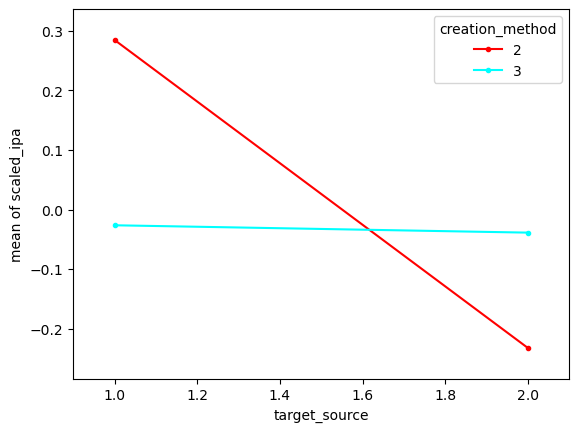

In [65]:
response =  mm_nav_data.loc[:, 'scaled_ipa']
x_factor = mm_nav_data.loc[:, 'target_source']
trace_factor = mm_nav_data.loc[:, 'creation_method']

fig = smgf.interaction_plot(x_factor, trace_factor, response)

In [ ]:
md_ipa = smf.mixedlm("scaled_ipa ~ C(method) + C(model) + C(creation_method) + C(target_source) + C(trial_id)" , mm_nav_data, groups=mm_nav_data["id"], re_formula='C(model)')
mdf_ipa = md_ipa.fit(method='lbfgs')
print(mdf_ipa.summary())

                   Mixed Linear Model Regression Results
Model:                    MixedLM       Dependent Variable:       scaled_ipa
No. Observations:         230           Method:                   REML      
No. Groups:               29            Scale:                    0.5199    
Min. group size:          7             Log-Likelihood:           -297.9882 
Max. group size:          8             Converged:                Yes       
Mean group size:          7.9                                               
----------------------------------------------------------------------------
                                  Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------------------
Intercept                          0.511    0.205  2.487 0.013  0.108  0.913
C(method)[T.1]                    -0.262    0.096 -2.730 0.006 -0.451 -0.074
C(model)[T.1]                     -0.351    0.168 -2.085 0.037 -0.681 -0.021
C(model)[T.2]      

In [ ]:
md_ipa2 = smf.mixedlm("scaled_ipa ~ C(model) + C(creation_method) + C(target_source) + C(trial_id)" , mm_nav_data, groups=mm_nav_data["id"], re_formula='C(model)')
mdf_ipa2 = md_ipa2.fit(method='lbfgs')
print(mdf_ipa2.summary())

                   Mixed Linear Model Regression Results
Model:                    MixedLM       Dependent Variable:       scaled_ipa
No. Observations:         230           Method:                   REML      
No. Groups:               29            Scale:                    0.5435    
Min. group size:          7             Log-Likelihood:           -300.1808 
Max. group size:          8             Converged:                Yes       
Mean group size:          7.9                                               
----------------------------------------------------------------------------
                                  Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------------------
Intercept                          0.405    0.201  2.015 0.044  0.011  0.799
C(model)[T.1]                     -0.354    0.168 -2.103 0.035 -0.684 -0.024
C(model)[T.2]                     -0.208    0.171 -1.214 0.225 -0.544  0.128
C(model)[T.3]      

In [ ]:
md_tepr = smf.mixedlm("scaled_tepr ~ C(method)", mm_nav_data, groups=mm_nav_data["id"])
mdf_tepr = md_tepr.fit()
print(mdf_tepr.summary())

          Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: scaled_tepr
No. Observations: 230     Method:             REML       
No. Groups:       29      Scale:              0.2444     
Min. group size:  7       Log-Likelihood:     -213.6135  
Max. group size:  8       Converged:          Yes        
Mean group size:  7.9                                    
---------------------------------------------------------
               Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------
Intercept      -0.047    0.172 -0.276 0.782 -0.384  0.289
C(method)[T.1]  0.099    0.065  1.513 0.130 -0.029  0.227
Group Var       0.791    0.475                           



In [ ]:
md_tepr = smf.mixedlm("scaled_tepr ~ C(model)", mm_nav_data, groups=mm_nav_data["id"])
mdf_tepr = md_tepr.fit()
print(mdf_tepr.summary())

          Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: scaled_tepr
No. Observations: 230     Method:             REML       
No. Groups:       29      Scale:              0.2253     
Min. group size:  7       Log-Likelihood:     -207.4354  
Max. group size:  8       Converged:          Yes        
Mean group size:  7.9                                    
---------------------------------------------------------
               Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------
Intercept      -0.177    0.176 -1.001 0.317 -0.523  0.169
C(model)[T.1]   0.074    0.089  0.834 0.404 -0.100  0.247
C(model)[T.2]   0.338    0.089  3.812 0.000  0.164  0.511
C(model)[T.3]   0.306    0.088  3.471 0.001  0.133  0.479
Group Var       0.790    0.493                           



In [ ]:
md_seq = smf.mixedlm("scaled_seq ~ C(method)", mm_nav_data, groups=mm_nav_data["id"])
mdf_seq = md_seq.fit()
print(mdf_seq.summary())

          Mixed Linear Model Regression Results
Model:             MixedLM Dependent Variable: scaled_seq
No. Observations:  230     Method:             REML      
No. Groups:        29      Scale:              0.4399    
Min. group size:   7       Log-Likelihood:     -266.6016 
Max. group size:   8       Converged:          Yes       
Mean group size:   7.9                                   
---------------------------------------------------------
               Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------
Intercept      -0.314    0.144 -2.178 0.029 -0.596 -0.031
C(method)[T.1]  0.631    0.088  7.214 0.000  0.460  0.803
Group Var       0.489    0.235                           



In [ ]:
md_seq = smf.mixedlm("scaled_seq ~C(model)", mm_nav_data, groups=mm_nav_data["id"])
mdf_seq = md_seq.fit()
print(mdf_seq.summary())

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: scaled_seq
No. Observations: 230     Method:             REML      
No. Groups:       29      Scale:              0.5573    
Min. group size:  7       Log-Likelihood:     -291.4751 
Max. group size:  8       Converged:          Yes       
Mean group size:  7.9                                   
--------------------------------------------------------
              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------
Intercept     -0.027    0.162 -0.164 0.870 -0.343  0.290
C(model)[T.1]  0.064    0.139  0.459 0.646 -0.209  0.337
C(model)[T.2]  0.083    0.139  0.598 0.550 -0.190  0.356
C(model)[T.3] -0.020    0.139 -0.142 0.887 -0.291  0.252
Group Var      0.478    0.211                           



In [ ]:
md_fms = smf.mixedlm("scaled_discomfort ~C(method)", mm_nav_data, groups=mm_nav_data["id"])
mdf_fms = md_fms.fit()
print(mdf_fms.summary())

             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: scaled_discomfort
No. Observations: 230     Method:             REML             
No. Groups:       29      Scale:              0.1219           
Min. group size:  7       Log-Likelihood:     -145.5579        
Max. group size:  8       Converged:          Yes              
Mean group size:  7.9                                          
----------------------------------------------------------------
                 Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
----------------------------------------------------------------
Intercept        -0.066     0.179  -0.368  0.713  -0.417   0.285
C(method)[T.1]    0.124     0.046   2.695  0.007   0.034   0.214
Group Var         0.901     0.749                               



In [ ]:
md_fms = smf.mixedlm("scaled_discomfort ~C(model)", mm_nav_data, groups=mm_nav_data["id"])
mdf_fms = md_fms.fit()
print(mdf_fms.summary())

             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: scaled_discomfort
No. Observations: 230     Method:             REML             
No. Groups:       29      Scale:              0.1250           
Min. group size:  7       Log-Likelihood:     -150.6289        
Max. group size:  8       Converged:          Yes              
Mean group size:  7.9                                          
----------------------------------------------------------------
                 Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
----------------------------------------------------------------
Intercept        -0.030     0.182  -0.167  0.867  -0.387   0.327
C(model)[T.1]     0.054     0.066   0.822  0.411  -0.075   0.184
C(model)[T.2]     0.090     0.066   1.361  0.173  -0.039   0.219
C(model)[T.3]    -0.034     0.066  -0.519  0.604  -0.163   0.095
Group Var         0.900     0.739                               



## Creation Linear Mixed Models

In [ ]:
mm_crt_data = user_data_crt
mm_crt_data = mm_crt_data.reset_index(level=(0,1,2, 3))

mm_crt_data['block'] = mm_crt_data['block'].astype(block_cats).cat.codes
mm_crt_data['method'] = mm_crt_data['method'].astype(method_cats).cat.codes
mm_crt_data['model'] = mm_crt_data['model'].astype(model_cats).cat.codes
mm_crt_data['target_id'] = mm_crt_data['target_id'].astype(int)
mm_crt_data['trial_id'] = mm_crt_data['trial_id'].astype(int)
mm_crt_data['scaled_tepr'] = stats.zscore(mm_crt_data['adj_pupil']).astype('float64')
mm_crt_data['scaled_ipa'] = stats.zscore(mm_crt_data['IPA']).astype('float64')
mm_crt_data['scaled_time'] = stats.zscore(mm_crt_data['total_time']).astype('float64')
mm_crt_data['scaled_seq'] = stats.zscore(mm_crt_data['seq']).astype('float64')
mm_crt_data['total_interactions'] = mm_crt_data['Draw'] + mm_crt_data['Erase'] + mm_crt_data['PointPlaced'] + mm_crt_data['Move'] + mm_crt_data['PointDeleted']
mm_crt_data['scaled_interactions']  = stats.zscore(mm_crt_data['total_interactions']).astype('float64')

pd.options.display.float_format = '{:.5f}'.format
mm_crt_data.describe()

,block,model,method,trial_id,luminance,pupilDiameter,pupil_lum_base,adj_pupil,total_time,target_id,...,Move,Draw,Erase,PointDeleted,scaled_tepr,scaled_ipa,scaled_time,scaled_seq,total_interactions,scaled_interactions
count,232.00000,232.00000,232.00000,232.00000,232.00000,232.00000,232.00000,232.00000,232.00000,232.00000,...,232.00000,232.00000,232.00000,232.00000,232.00000,232.00000,232.00000,232.00000,232.00000,232.00000
mean,1.34483,1.50000,2.50000,1.50000,0.24261,3.71689,3.18699,0.52989,56.34086,1.50000,...,3.57759,2.57759,0.61638,0.26724,-0.00000,-0.00000,-0.00000,0.00000,11.79741,0.00000
std,1.12510,1.12045,0.50108,1.12045,0.03531,0.60435,0.51005,0.33050,35.36473,0.50108,...,7.77013,6.60860,2.44140,0.88134,1.00216,1.00216,1.00216,1.00216,12.67193,1.00216
min,0.00000,0.00000,2.00000,0.00000,0.16455,2.41991,2.16256,-0.14157,11.26140,1.00000,...,0.00000,0.00000,0.00000,0.00000,-2.03602,-2.07658,-1.27746,-0.83788,1.00000,-0.85392
25%,0.00000,0.75000,2.00000,0.75000,0.21317,3.22446,2.90728,0.26306,32.95855,1.00000,...,0.00000,0.00000,0.00000,0.00000,-0.80910,-0.62955,-0.66261,-0.83788,2.00000,-0.77483
50%,1.00000,1.50000,2.50000,1.50000,0.24110,3.71803,3.11354,0.50407,44.35440,1.50000,...,0.00000,0.50000,0.00000,0.00000,-0.07830,-0.06253,-0.33967,0.13406,8.00000,-0.30032
75%,2.00000,2.25000,3.00000,2.25000,0.27048,4.21177,3.51258,0.73177,69.87950,2.00000,...,2.00000,2.00000,0.00000,0.00000,0.61215,0.63215,0.38366,1.10601,15.00000,0.25328
max,3.00000,3.00000,3.00000,3.00000,0.32524,5.37301,4.24859,1.71331,217.87100,2.00000,...,38.00000,61.00000,19.00000,6.00000,3.58839,3.49412,4.57743,3.04990,79.00000,5.31473
